# PixelCNN for FashionMNIST

### In progress

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/05_autoregressive/02_pixelcnn/pixelcnn.ipynb)

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets
from torchvision import transforms as Transforms
import torchvision.utils as vuitls

import torchinfo



from torch.autograd import Variable

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## 0. Train Parameters

In [2]:
IMAGE_SIZE = 16
PIXEL_LEVELS = 12
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 150

## 1. Preparing FashionMNIST dataset

In [29]:
# class FashionData(Dataset):
#     def __init__(self):
#         transform_fn = Transforms.Compose([
#                     Transforms.ToTensor(),
#                     Transforms.Resize(IMAGE_SIZE, antialias=True),                        
#                 ])
        
#         # Load FashionMNIST dataset
#         fashion_ds = datasets.FashionMNIST('../../data', 
#                                           train=True, 
#                                           download=True,
#                                           transform=transform_fn)
        
#         self.data = torch.stack([data[0] for data in fashion_ds])
#         self.length = len(fashion_ds)

#     def __len__(self):
#         return self.length

#     def __getitem(self, idx):
#         raise NotImplementedError

In [30]:
# ds = FashionData()

torch.Size([60000, 1, 16, 16])


In [7]:
# Turn input image into (label-pixel representatin, pixel-wise labels)
# def collate_fn(batch):
#     batch = torch.stack([data[0] for data in batch])
#     value_step = 1.0 / PIXEL_LEVELS
#     labels = (batch / value_step).type(torch.long)
#     imgs = labels.type(torch.float32) / PIXEL_LEVELS
#     return imgs, labels

def get_dataloader():
    transform_fn = Transforms.Compose([
                        Transforms.ToTensor(),
                        Transforms.Resize(IMAGE_SIZE, antialias=True),                        
                    ])
    
    # Load FashionMNIST dataset
    fashion_ds = datasets.FashionMNIST('../../data', 
                                      train=True, 
                                      download=True,
                                      transform=transform_fn)

    # Get train dataloader
    train_loader = DataLoader(fashion_ds, batch_size=BATCH_SIZE, shuffle=True,
                              # collate_fn=collate_fn)
                             )

    return train_loader

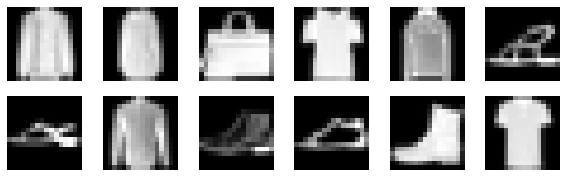

In [9]:
# Check dataset
def plot_imgs(batch, num_rows=2, num_cols=6):
    plt.figure(figsize=(10, 3))
    for i in range(num_rows * num_cols):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(batch[i].permute(1, 2, 0), cmap='gray')
        ax.axis('off')
    plt.show()

test_loader = get_dataloader()
sample_data = next(iter(test_loader))

plot_imgs(sample_data[0])

## 2. Build the PixelCNN

This PyTorch implementation references pi-tau's GitHub repo: [Link](https://github.com/pi-tau/pixelcnn/blob/master/conv2d_mask.py)

In [10]:
# Building MaskedConv2D layer
class MaskedConv2D(nn.Conv2d):
    
    def __init__(self, mask_type, in_channels, out_channels, kernel_size, **kwargs):
        kwargs['padding'] = 'same'
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)

        assert mask_type in ['A', 'B'], 'Mask type should be either A or B'
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)

        # Creating masks
        kh, kw = kernel_size
        mask = torch.ones_like(self.weight)
        mask[:, :, (kh // 2 + 1):, :] = 0
        mask[:, :, (kh // 2), (kw // 2 + 1):] = 0
        # If mask type is A, then masking the center pixel
        if mask_type == 'A':
            mask[:, :, (kh // 2), (kw // 2)] = 0

        # Making the mask the non-trainable parameter of the module
        self.register_buffer('mask', mask)

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2D, self).forward(x)

In [11]:
# Check the mask in the masked conv layer
print("Type \"A\" mask of the conv layer:")
print(MaskedConv2D('A', 1, 1, 5).mask.numpy())

print("\nType \"B\" mask of the conv layer:")
print(MaskedConv2D('B', 1, 1, 5).mask.numpy())

Type "A" mask of the conv layer:
[[[[1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]]]

Type "B" mask of the conv layer:
[[[[1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]]]


In [12]:
# Building the residual block
class ResidualBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv_1 = nn.Sequential(
                        nn.Conv2d(in_channels=in_channels, 
                                  out_channels=out_channels // 2,
                                  kernel_size=1, padding='valid',
                                  stride=1,
                                  bias=False),
                        nn.ReLU())

        self.pixel_conv = nn.Sequential(
                        MaskedConv2D(
                            mask_type='B',
                            in_channels=out_channels // 2,
                            out_channels=out_channels // 2,
                            kernel_size=3,
                            padding='same',
                            bias=False),
                        nn.ReLU())

        self.conv_2 = nn.Sequential(
                        nn.Conv2d(in_channels=out_channels // 2,
                                  out_channels=out_channels,
                                  kernel_size=1,
                                  padding='valid',
                                  bias=False),
                        nn.ReLU())

    
    def forward(self, x):
        conv_x = self.conv_1(x)
        conv_x = self.pixel_conv(conv_x)
        conv_x = self.conv_2(conv_x)
        return conv_x + x        

In [36]:
# Check the residual block
# model = ResidualBlock(4, 4)
# torchinfo.summary(model=model, input_size=(1, 4, 32, 32))

In [13]:
class PixelCNN(nn.Module):

    def __init__(self, num_filters, num_res_blocks, ouput_size=PIXEL_LEVELS):
        super().__init__()
        self.masked_conv_1 = nn.Sequential( 
                                MaskedConv2D(
                                    mask_type='A',
                                    in_channels=1,
                                    out_channels=num_filters,
                                    kernel_size=7,
                                    padding='same'),
                                nn.ReLU()
                             )

        self.res_convs = nn.Sequential(*[
                            ResidualBlock(
                                in_channels=num_filters,
                                out_channels=num_filters)
                            for _ in range(num_res_blocks)])

        self.masked_conv_2 = nn.Sequential(*[
                                nn.Sequential(
                                    MaskedConv2D(
                                        mask_type='B',
                                        in_channels=num_filters,
                                        out_channels=num_filters,
                                        kernel_size=1,
                                        padding='valid'),
                                    nn.ReLU())
                                for _ in range(2)],
                            )

        self.output_conv = nn.Conv2d(in_channels=num_filters,
                                     out_channels=ouput_size,
                                     kernel_size=1,
                                     stride=1,
                                     padding='valid')
        # We don't need a softmax layer when using CrossEntropy Loss in PyTorch

    def forward(self, x):
        x = self.masked_conv_1(x)
        x = self.res_convs(x)
        x = self.masked_conv_2(x)
        x = self.output_conv(x)
        return x

model = PixelCNN(N_FILTERS, RESIDUAL_BLOCKS)
torchinfo.summary(model=model, input_size=(1, 1, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
PixelCNN                                 [1, 12, 16, 16]           --
├─Sequential: 1-1                        [1, 128, 16, 16]          --
│    └─MaskedConv2D: 2-1                 [1, 128, 16, 16]          6,400
│    └─ReLU: 2-2                         [1, 128, 16, 16]          --
├─Sequential: 1-2                        [1, 128, 16, 16]          --
│    └─ResidualBlock: 2-3                [1, 128, 16, 16]          --
│    │    └─Sequential: 3-1              [1, 64, 16, 16]           8,192
│    │    └─Sequential: 3-2              [1, 64, 16, 16]           36,864
│    │    └─Sequential: 3-3              [1, 128, 16, 16]          8,192
│    └─ResidualBlock: 2-4                [1, 128, 16, 16]          --
│    │    └─Sequential: 3-4              [1, 64, 16, 16]           8,192
│    │    └─Sequential: 3-5              [1, 64, 16, 16]           36,864
│    │    └─Sequential: 3-6              [1, 128, 16, 16]        

## 3. Define the model, dataloader, objective, and optimizer

In [14]:
pixel_cnn = PixelCNN(N_FILTERS, RESIDUAL_BLOCKS).to(DEVICE)

# if torch.__version__.split('.')[0] == '2':
#     torch.set_float32_matmul_precision('high')
#     # It is important to use eager backend here to avoid
#     # distribution mismatch in training and predicting
#     pixel_cnn = torch.compile(pixel_cnn, dynamic=True)
#     print('model compiled')

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(pixel_cnn.parameters(), lr=1e-3)

train_loader = get_dataloader()

## 4. Traineer function

In [15]:
def trainer(model, dataloader, loss_fn, optim):
    model.train()
    train_loss = 0
    
    for imgs, _ in dataloader:
        optim.zero_grad()
        # imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        imgs = imgs.to(DEVICE)
        logits = model(imgs)
        logits = logits.reshape(-1, PIXEL_LEVELS)
        # labels = labels.reshape(-1)
        target = Variable(imgs.data.reshape(-1) * PIXEL_LEVELS).long()
        loss = loss_fn(preds, labels)
        loss.backward()
        optim.step()

        train_loss += loss.item()

    return train_loss / len(dataloader)

In [16]:
for i in range(EPOCHS):
    loss = trainer(model, train_loader, loss_fn, optim)
    print(loss)

2.4846654690659125
2.484665539218927
2.4846654934669608
2.4846654807580815
2.4846654843165674
2.484665516342944
2.4846655127844577
2.4846654751661745
2.484665546844255
2.484665519393075
2.484665499567223
2.4846654583904533
2.4846654934669608
2.48466542077217
2.484665437039536
2.484665519393075
2.4846654919418953
2.4846654807580815
2.4846655260016925
2.4846655402356372
2.4846654792330156
2.4846655153262334
2.4846654665241363
2.4846655234599164


KeyboardInterrupt: 